In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.init import normal, constant
from torch import nn
from matplotlib import pyplot as plt
# from attorch.train import early_stopping
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler


torch.cuda.empty_cache()


In [3]:
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn import preprocessing

from notebooks.imports import *
from config import dir_config
from src.utils.glm_hmm_utils import *
import pickle
import copy
from itertools import count

In [4]:
from src.bayesian_encoding.model import Net
from src.bayesian_encoding.utils import set_seed

### Config

In [5]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

In [7]:
# reject sessions
session_to_exclude = ["210210_GP_JP","241209_GP_TZ"]

session_metadata = pd.read_csv(Path(compiled_dir, "sessions_metadata.csv"))
neuron_metadata = pd.read_csv(Path(compiled_dir, "neuron_metadata.csv"))

session_metadata = session_metadata[~session_metadata["session_id"].isin(session_to_exclude)]
neuron_metadata = neuron_metadata[~neuron_metadata["session_id"].isin(session_to_exclude)]

with open(Path(processed_dir, "glm_hmm_all_trials_prior_based_initialization_final.pkl"), "rb") as f:
	glm_hmm = pickle.load(f)

with open(Path(processed_dir, "ephys_neuron_wise.pkl"), "rb") as f:
	ephys = pickle.load(f)

In [8]:
coh = [-50, -20, -6, 0, 6, 20, 50]

equal_prior = np.array([0.125, .125, .125, .25, .125, .125, .125])
toRF_prior = np.array([0.075, 0.075, 0.075, 0.25, 0.175, 0.175, 0.175])
awayRF_prior = np.array([0.175, 0.175, 0.175, 0.25, 0.075, 0.075, 0.075])

### Helper Functions

In [9]:
def get_session_neural_data(epoch, valid_trial_filter, neuron_ids):
	"""return 3d array of shape (num_neurons, num_trials, num_time_bins)"""
	neural_data = []
	for neuron_id in neuron_ids:
		neural_data.append(ephys[epoch][neuron_id]['convolved_spike_trains'])
	neural_data = np.array(neural_data)
	neural_data = neural_data[:, valid_trial_filter, :]
	return neural_data


### Aggregate Sessions

In [52]:
toRF_trial_freq_by_coh_and_prior = np.empty((len(session_metadata), 2, len(coh)))*np.nan
awayRF_trial_freq_by_coh_and_prior = np.empty((len(session_metadata), 2, len(coh)))*np.nan
# aggregate all sessions
for session_idx, session_id in enumerate(session_metadata.session_id):
	trial_data = glm_hmm['session_wise']['data'][session_id]
	valid_trial_filter = np.where((trial_data['mask'] == 1) & (~np.isnan(trial_data['reaction_time'])))[0]
	trial_data = trial_data.iloc[valid_trial_filter]
	trial_data = trial_data[
		((trial_data['stimulus'] > 0) & (trial_data['choices'] == 1)) |
		((trial_data['stimulus'] < 0) & (trial_data['choices'] == 0)) |
		(trial_data['stimulus'] == 0)
	]
	trial_data_count = trial_data.groupby(['prob_toRF', 'stimulus']).size().reset_index(name='freq')

	prior_dir = session_metadata[session_metadata["session_id"] == session_id].prior_direction.values[0]
	if prior_dir == "toRF":
		toRF_trial_freq_by_coh_and_prior[session_idx, :, :] = np.array(trial_data_count.freq).reshape(2, len(coh))
	elif prior_dir == "awayRF":
		awayRF_trial_freq_by_coh_and_prior[session_idx, :, :] = np.array(trial_data_count.freq).reshape(2, len(coh))[::-1]

# 	if session_metadata[session_metadata["session_id"] == session_id].prior_direction.values[0] == "toRF":
# 		toRF_trial_freq_by_coh_and_prior[session_idx, :, :] = np.array(trial_data_count.freq).reshape(2, len(coh))
# 	elif session_metadata[session_metadata["session_id"] == session_id].prior_direction.values[0] == "awayRF":
# 		awayRF_trial_freq_by_coh_and_prior[session_idx, :, :] = np.array(trial_data_count.freq).reshape(2, len(coh))[::-1]

toRF_min_trial_per_condition = np.nanmin(toRF_trial_freq_by_coh_and_prior, axis=0).astype(int)
awayRF_min_trial_per_condition = np.nanmin(awayRF_trial_freq_by_coh_and_prior, axis=0).astype(int)
toRF_min_trial_per_condition, awayRF_min_trial_per_condition

(array([[ 48,  41,  27,  48,  14,  33,  46],
        [ 41,  27,  13,  86,  61, 100, 108]]),
 array([[49, 37, 17, 48, 29, 43, 49],
        [65, 61, 50, 45,  9, 20, 26]]))

In [55]:
epoch = 'response_onset'
agg_toRF_neuron_data = []
agg_awayRF_neuron_data = []

# randomly draw trials from each session
for session_idx, session_id in enumerate(session_metadata.session_id):
	trial_data = glm_hmm['session_wise']['data'][session_id]
	valid_trial_filter = np.where((trial_data['mask'] == 1) & (~np.isnan(trial_data['reaction_time'])))[0]
	trial_data = trial_data.iloc[valid_trial_filter]
	trial_data = trial_data[
		((trial_data['stimulus'] > 0) & (trial_data['choices'] == 1)) |
		((trial_data['stimulus'] < 0) & (trial_data['choices'] == 0)) |
		(trial_data['stimulus'] == 0)
	]

	neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values

	toRF_trial_indices = {'eq': [], 'uneq': []}
	awayRF_trial_indices = {'eq': [], 'uneq': []}

	# randomly draw n trials from each session
	for coh_idx, coh_val in enumerate(coh):
		equal_trials = np.where((trial_data['prob_toRF'] == 50) & (trial_data['stimulus'] == coh_val/100))[0]
		unequal_trials = np.where((trial_data['prob_toRF'] != 50) & (trial_data['stimulus'] == coh_val/100))[0]

		if session_metadata['prior_direction'].iloc[session_idx] == "toRF":
			toRF_trial_indices['eq'].append(npr.choice(equal_trials, size=toRF_min_trial_per_condition[0, coh_idx], replace=False))
			toRF_trial_indices['uneq'].append(npr.choice(unequal_trials, size=toRF_min_trial_per_condition[1, coh_idx], replace=False))

		elif session_metadata['prior_direction'].iloc[session_idx] == "awayRF":
			awayRF_trial_indices['eq'].append(npr.choice(equal_trials, size=awayRF_min_trial_per_condition[0, coh_idx], replace=False))
			awayRF_trial_indices['uneq'].append(npr.choice(unequal_trials, size=awayRF_min_trial_per_condition[1, coh_idx], replace=False))


	if session_metadata['prior_direction'].iloc[session_idx] == "toRF":
		all_trial_indices = np.hstack(toRF_trial_indices['eq'] + toRF_trial_indices['uneq'])
		agg_toRF_neuron_data.append(get_session_neural_data(epoch=epoch, valid_trial_filter=all_trial_indices, neuron_ids=neuron_ids))
	elif session_metadata['prior_direction'].iloc[session_idx] == "awayRF":
		all_trial_indices = np.hstack(awayRF_trial_indices['eq'] + awayRF_trial_indices['uneq'])
		agg_awayRF_neuron_data.append(get_session_neural_data(epoch=epoch, valid_trial_filter=all_trial_indices, neuron_ids=neuron_ids))

agg_toRF_neuron_data = np.vstack(agg_toRF_neuron_data)
agg_awayRF_neuron_data = np.vstack(agg_awayRF_neuron_data)
agg_toRF_neuron_data.shape, agg_awayRF_neuron_data.shape

((86, 693, 351), (81, 548, 351))

#### prior

In [58]:
import numpy.matlib as matlib

In [59]:
prior_toRF = np.vstack((np.vstack([matlib.repmat(equal_prior,trial_num,1) for trial_num in toRF_min_trial_per_condition[0,:]]),
                       np.vstack([matlib.repmat(toRF_prior,trial_num,1) for trial_num in toRF_min_trial_per_condition[1,:]])))

prior_awayRF = np.vstack((np.vstack([matlib.repmat(equal_prior,trial_num,1) for trial_num in awayRF_min_trial_per_condition[0,:]]),
                       np.vstack([matlib.repmat(awayRF_prior,trial_num,1) for trial_num in awayRF_min_trial_per_condition[1,:]])))

#### t

In [ ]:
t_toRF = np.repeat([coh,coh],toRF_min_trial_per_condition.flatten())
t_awayRF = np.repeat([coh,coh],awayRF_min_trial_per_condition.flatten())

### toRF session fit

---

In [132]:
stim_map = {stim: i for i, stim in enumerate(np.sort(coh))}
delta = 1

x = torch.tensor(np.nansum(agg_toRF_neuron_data[:, :, 200:300], axis=2).T, dtype=torch.float32, device="cuda")
t = torch.tensor([stim_map[stim] for stim in t_toRF], dtype=torch.long, device="cuda")
prior = torch.tensor(prior_toRF, dtype=torch.float32, device="cuda")

### Fixed Likelihood

###  Test train split

In [100]:
from scripts.likelihood_models import FixedLikelihoodNet

In [143]:
def train_full_likelihood_model(data_loader, hyperparameters):
	"""
	Train the neural network on the full likelihood model with mini-batch training.
	"""
	# Unpack hyperparameters
	n_hidden = hyperparameters.get('n_hidden', [500, 500])
	n_epoch = hyperparameters.get('n_epoch', 1000)
	batch_size = hyperparameters.get('batch_size', 32)
	learning_rate = hyperparameters.get('learning_rate', 1e-3)
	weight_decay = hyperparameters.get('weight_decay', 1e-5)
	dropout = hyperparameters.get('dropout', 0.5)
	std = hyperparameters.get('std', 0.001)
	alpha = hyperparameters.get('alpha', 1.0)
	beta = hyperparameters.get('beta', 1.0)
	loss_fn = hyperparameters.get('loss_fn', nn.CrossEntropyLoss().cuda())

	# Move data to GPU
	input, target, prior = next(iter(train_loader))


	# Initialize Model
	net = FixedLikelihoodNet(n_channel=input.shape[1], n_output=len(target.unique()), n_hidden=n_hidden, std=std, dropout=dropout)
	net.cuda()
	net.initialize()

	optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
	torch.autograd.set_detect_anomaly(True)

	for epoch in range(n_epoch):
		net.train()
		epoch_loss = 0.0  # Track loss per epoch

		for batch_input, batch_target, batch_prior in data_loader:
			optimizer.zero_grad()

			y = net(batch_input)

			# Check for NaNs in output
			if torch.isnan(y).any() or torch.isinf(y).any():
				print(f"NaNs/Infs detected in output y at epoch {epoch}")
				break

			post = y + batch_prior
			post = post - post.max(1, keepdim=True)[0]  # Stabilize softmax

			# Check for NaNs in post
			if torch.isnan(post).any() or torch.isinf(post).any():
				print(f"NaNs/Infs detected in post at epoch {epoch}")
				break

			conv_filter = torch.tensor([-0.25, 0.5, -0.25], dtype=torch.float32, device="cuda").reshape(1, 1, -1)
			smoothness = nn.functional.conv1d(y.unsqueeze(1), conv_filter).pow(2).mean()

			if beta > 0:
				l2 = net.l2_weights_per_layer()
			else:
				l2 = 0

			loss = loss_fn(post, batch_target) + alpha * smoothness + beta * l2
			epoch_loss += loss.item()

			# Check for NaNs in loss
			if torch.isnan(loss).any() or torch.isinf(loss).any():
				print(f"NaNs/Infs detected in loss at epoch {epoch}")
				break

			loss.backward()

			# Check gradients for NaNs
			for param in net.parameters():
				if param.grad is not None and torch.isnan(param.grad).any():
					print("NaNs detected in gradients")
					break

			# # Apply gradient clipping
			# torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

			optimizer.step()

		if epoch % 100 == 0:
			print(f'Epoch {epoch}/{n_epoch}, Avg Loss: {epoch_loss / len(data_loader):.6f}')

	return net, batch_input, batch_target, batch_prior


In [134]:
dataset = TensorDataset(x, t, prior)

# Define the lengths for each split
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remainder for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Extract train_labels from train dataset
train_labels = torch.tensor([dataset[i][1] for i in train_dataset.indices], dtype=torch.long)
# Compute class frequencies
labels, counts = torch.unique(train_labels, return_counts=True)
class_weights = 1. / counts.float()  # Inverse frequency for each class
sample_weights = class_weights[train_labels]  # Assign weight based on label index
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

In [136]:
# Create DataLoader with sampler (No shuffle needed)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

hyperparameters = {
	'n_hidden': [500, 500], # number of hidden units in each layer
	'n_epoch': 1000, # number of epochs
	'batch_size': 32, # batch size
	'learning_rate': 1e-3, # learning rate
	'weight_decay': 0,# 1e-6, # weight decay
	'dropout': 0.2, # dropout rate
	'std': 0.01, # std for initializing weights
	'alpha': 1.0, # weight on KL divergence term3
	'loss_fn': nn.CrossEntropyLoss(), # loss function
	'beta': 0.1 # weight on l2 normalization
}

In [145]:
hyperparameters = {
    'n_hidden': [1024, 512],
    'n_epoch': 500,
    'batch_size': 1,
    'learning_rate': 1e-3,
    'weight_decay': 0.0,
    'dropout': 0.5,
    'std': 0.01,
    'alpha': 0.0,  # turn off smoothness
    'beta': 0.0,   # turn off L2
    'loss_fn': nn.CrossEntropyLoss()
}


net, input_train, target_train, prior_train = train_full_likelihood_model(train_loader, hyperparameters)

Epoch 0/500, Avg Loss: 1.942250
Epoch 100/500, Avg Loss: 1.939286
Epoch 200/500, Avg Loss: 1.942256
Epoch 300/500, Avg Loss: 1.941013
Epoch 400/500, Avg Loss: 1.943946


In [151]:
input_val, target_val, prior_val = next(iter(val_loader))
calculate_accuracy(net, input_train, prior_train, target_train), calculate_accuracy(net, input_val, prior_val, target_val)

(14.432989690721648, 26.21359223300971)

In [152]:
objective(net, input_train, prior_train, target_train), objective(net, input_val, prior_val, target_val)

(array(1.98343657), array(2.08088853))

In [67]:
def objective(net, x=None, prior=None, t=None):
	if x is None and t is None:
		return None
	net.eval()
	y = net(x)
	posterior = y + prior
	_, loc = torch.max(posterior, dim=1)
	v =(t.double() - loc.double()).pow(2).mean().sqrt() * delta
	return v.data.cpu().numpy()

In [68]:
def calculate_accuracy(net, x=None, prior=None, t=None):
	"""Calculate accuracy of the model"""
	t = t.cpu().numpy()
	y = net(x)+ prior
	y = y.data.cpu().numpy()
	y = np.exp(y)
	y = y / y.sum(axis=1, keepdims=True)
	pred = np.argmax(y, axis=1)
	return np.mean(pred == t) * 100

In [72]:
y = net(input_val)
y = y.data.cpu().numpy()
y = np.exp(y)
yd = y / y.sum(axis=1, keepdims=True)

In [ ]:
nbins = 7

pv = (np.arange(nbins) - nbins//2) * delta

loc = yd.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2
avg_sigma = np.mean(np.sqrt(np.sum(yd * ds, axis=1))) * delta

n_rows = 5
n_cols = 6
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
for c, ((i, j), ax) in zip(count(), np.ndenumerate(axs)):
    c = npr.randint(0, len(yd))  # Randomize to avoid deterministic behavior in plotting
    ax.plot(pv, yd[c])
    ax.scatter(pv[t_[c]],0.4, color='red', marker='x', s=1)
    ax.set_ylim([0, 1])
    ax.set_yticks([])
    if j == 0 and i == n_rows-1:
        ax.set_ylabel('Likelihood (a.u.)')
        ax.set_xlabel('Coherence (%)')
    else:
        ax.set_xticklabels([])

fig.suptitle("$\mathbf{{E}}[\sigma]$={:0.3f}".format(avg_sigma), fontsize=14)

NameError: name 'bin_width' is not defined

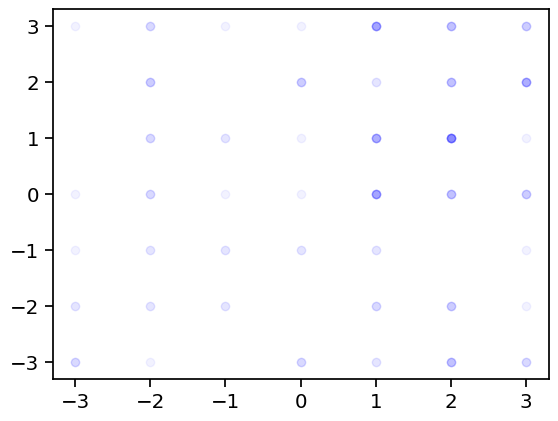

In [ ]:
plt.figure()
coh_hat = np.array([pv[np.argmax(yd[i])] for i in range(len(yd))])
plt.scatter(coh_hat, target_val.cpu()-3, color='blue', alpha=0.05)
plt.show()